# Лабораторная работа №1. Математическое прогнозирование

Стрельницкая Татьяна, группа J4140

Цель работы: исследовать модель Хольта-Уинтерса и освоить ее реализацию

Постановка задачи: необходимо предсказать средний объем продаж для магазина на основе исторических данных

Датасет взят с kaggle: https://www.kaggle.com/code/egorkainov/timeseries-forecasting-tutorial/input?select=train.csv

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [212]:
df = pd.read_csv("./train_sales.csv")

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         230090 non-null  object
 1   store        230090 non-null  int64 
 2   product      230090 non-null  int64 
 3   number_sold  230090 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.0+ MB


In [214]:
df.head()

,Date,store,product,number_sold
0,2010-01-01,0,0,801
1,2010-01-02,0,0,810
2,2010-01-03,0,0,818
3,2010-01-04,0,0,796
4,2010-01-05,0,0,808


Предобработаем данные для дальнейшей работы. Основная цель - посчитать среднее значение продаж по месяцам, так как именно эту величину в дальнейшем потом и будем прогнозировать

In [215]:
df['Date'] = pd.to_datetime(df['Date'])
df['YearMonth'] = df['Date'].dt.to_period('M')
monthly_series = df.groupby('YearMonth')['number_sold'].agg(Avg_number_sold='mean').reset_index()
monthly_series['Date'] = monthly_series['YearMonth'].dt.to_timestamp()
monthly_series = monthly_series[['Date', 'Avg_number_sold']]

monthly_series.head()

,Date,Avg_number_sold
0,2010-01-01,782.674194
1,2010-02-01,780.484694
2,2010-03-01,778.058986
3,2010-04-01,776.665714
4,2010-05-01,776.608295


Посмотрим на график, чтобы убедиться в том, что данные имеют определенную сезонность

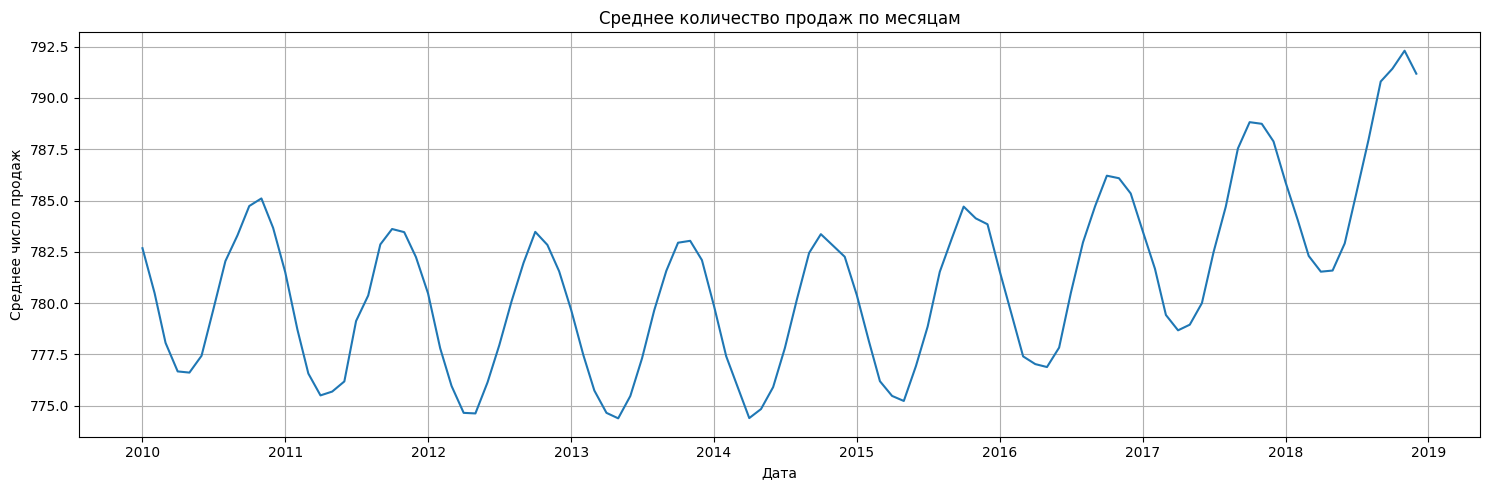

In [224]:
plt.figure(figsize=(15, 5))
sns.lineplot(x='Date', y='Avg_number_sold', data=monthly_series)
plt.title('Среднее количество продаж по месяцам')
plt.xlabel('Дата')
plt.ylabel('Среднее число продаж')
plt.grid(True)
plt.tight_layout()
plt.show()

In [217]:
df = monthly_series['Avg_number_sold']

### Построение и запуск модели

Этапы реализации модели:
1. вычисление тренда и начальных a(0) и b(0)
2. вычисление значений по тренду, стандартных отклонений и первых значений F(-11) - F(0)
3. расчет остальных значений a, b и F
4. расчет прогнозных значений 
5. расчет остатков и MAPE на тренировочном и тестовом множествах для комплексной оценки работы модели (конечная оценка при подборе гиперпараметров идет по значению MAPE на тренировочном множестве)

In [218]:
def holt_winters_additive(df, alpha1, alpha2, alpha3, n_seasons, n_pred):

    df_train = np.array(df[:-(n_seasons * n_pred)])
    df_test = np.array(df[-(n_seasons * n_pred):])

    n_periods = int(len(df_train) / n_seasons)

    # вычисление тренда и начальных a(0) и b(0)
    x = np.arange(1, len(df_train)+1)
    y = np.array(df_train)
    a, b = np.polyfit(x, y, 1) 

    # вычисление значений по тренду, стандартных отклонений и первых значений F(-11) - F(0)
    trend = []
    std_o = []
    for i in range(1, len(df_train)+1):
        trend.append(a * i + b)
        std_o.append(df_train[i-1] / trend[i-1])

    F_t = []
    for i in range(n_seasons):
        sum_std_month = 0
        for j in range(i, len(df_train), n_seasons):
            sum_std_month += std_o[j]
        F_t.append(sum_std_month/n_periods)
    
    # рассчитываем дальше значения a, b и F
    b_t = [b, ]
    a_t = [a, ]

    for i in range(len(df_train)):
        b_t.append(alpha1 * (df_train[i] / F_t[i]) + (1 - alpha1) * (b_t[i] + a_t[i]))
        a_t.append(alpha2 * (b_t[i + 1] - b_t[i]) + (1 - alpha2) * a_t[i])
        F_t.append(alpha3 * (df_train[i] / b_t[i + 1]) + (1 - alpha3) * F_t[i])

    # берем нужные значения и рассчитываем прогнозные значения уже по ним
    a_n = a_t[-1]
    b_n = b_t[-1]
    F_final = F_t[-n_seasons:]
    X_t = []

    for i in range(n_periods):
        for j in range(1, n_seasons + 1):
            X_t.append((a_n * j + b_n) * F_final[j - 1])

    # для оценки прогноза рассчитываем остатки и MAPE
    ost_train = []
    for_mape_train = []
  
    for i in range(len(df_train)):
        ost_train.append(X_t[i] - df_train[i])  
        for_mape_train.append(abs(ost_train[i]) / df_train[i])
    mape_train = sum(for_mape_train) / len(for_mape_train)


    pred = []
    for i in range(n_pred):
        for j in range(n_seasons):
            pred.append((a_n * (j + 1) + b_n) * F_final[j]) 
            
    
    # для оценки прогноза рассчитываем остатки и MAPE на тесте
    ost_test = []
    for_mape_test = []
    for i in range(len(df_test)):
        ost_test.append(pred[i] - df_test[i])  
        for_mape_test.append(abs(ost_test[i]) / df_test[i])
    mape_test = sum(for_mape_test) / len(for_mape_test)
 
    return a_n, b_n, F_final, pred, mape_train, mape_test, X_t

В данном случае отображен запуск модели и результаты для оптимального набора гиперпараметров, подобранных далее

In [219]:
# запуск модели с заданными параметрами
alpha1 = 0.1
alpha2 = 0.3
alpha3 = 0.7

n_seasons =  36
n_pred = 1

a_n, b_n, F_final, pred, mape_train, mape_test, X_t = holt_winters_additive(df, alpha1, alpha2, alpha3, n_seasons, n_pred)

# вывод результатов
print("Параметры модели:")
print(f"Линейная трендовая компонента (a), n-ное значение: {a_n:.4f}")
print(f"Постоянная (опорная) компонента (b), n-ное значение: {b_n:.4f}")
print(f"Последние {n_seasons} значений сезонной компоненты:")
print(F_final)
print(f"Прогноз на {n_pred} период(а):")
for i in range(n_pred):
    print(f"Прогноз на сезон {i + 1}:")
    s1 = i * n_seasons
    s2 = s1 + n_seasons
    print(pred[s1:s2])
print(f"mape на train: {mape_train:.4f}")
print(f"mape на test: {mape_test:.4f}")

Параметры модели:
Линейная трендовая компонента (a), n-ное значение: -0.0089
Постоянная (опорная) компонента (b), n-ное значение: 780.0362
Последние 36 значений сезонной компоненты:
[1.0023027995335094, 0.9996318568127701, 0.9972765741946881, 0.995822114722914, 0.99557568365755, 0.9968729307950321, 0.9993515581897512, 1.0023167954711671, 1.0044747180877276, 1.0061299299686621, 1.0062164731925602, 1.0046842966583642, 1.001665754240456, 0.9982402285218701, 0.9959476294805469, 0.9939050599725011, 0.9942118758244346, 0.9952083662623739, 0.9978905844654061, 1.0004469093021353, 1.0033213489006352, 1.004374407420219, 1.003781711553081, 1.002852042379394, 1.000500252029446, 0.9974954114960756, 0.9950945689114086, 0.9940139563366397, 0.9938298770973, 0.9960112266986886, 0.9985083590027298, 1.0017899561822516, 1.0040282068776838, 1.0060482458810913, 1.0053400972515087, 1.00463135220188]
Прогноз на 1 период(а):
Прогноз на сезон 1:
[781.8235553346392, 779.731240358164, 777.8851908531723, 776.74182

Визуализируем прогнозы модели для наглядного сравнения

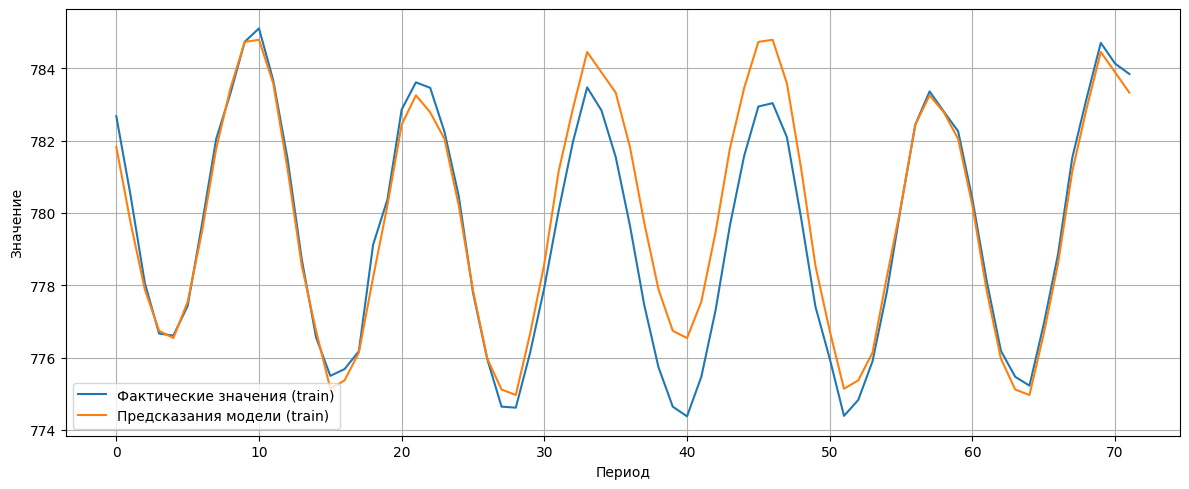

In [220]:
df_train = np.array(df[:-(n_seasons * n_pred)])
df_test = np.array(df[-(n_seasons * n_pred):])

# сравнение на трейне
plt.figure(figsize=(12, 5))
plt.plot(df_train, label='Фактические значения (train)')
plt.plot(X_t, label='Предсказания модели (train)')
plt.xlabel('Период')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

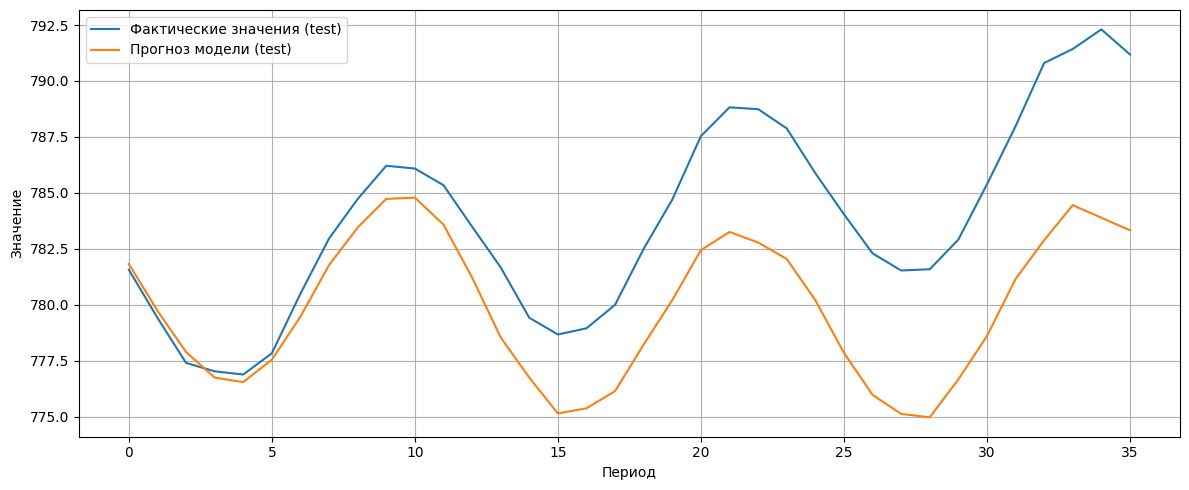

In [221]:
# сравнение на тесте
plt.figure(figsize=(12, 5))
plt.plot(df_test, label='Фактические значения (test)')
plt.plot(pred[:len(df_test)], label='Прогноз модели (test)')
plt.xlabel('Период')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Тюнинг гиперпараметров

Тюнинг такого параметра как количество сезонов произведен в рамках от минимального, указанного в требованиях (4 сезона), до максимального (равного половине значений тренировочного множества)

In [222]:
def tune_holt_winters(df, n_pred):
    best_mape_test = float('inf')
    best_params = None
    best_result = None

    alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    season_lens = []
    for i in range(4, len(df) // 2 + 1):
        if len(df) % i == 0:
            season_lens.append(i)

    for alpha1 in alphas:
        for alpha2 in alphas:
            for alpha3 in alphas:
                for n_seasons in season_lens:
                    try:
                        a_n, b_n, F_final, pred, mape_train, mape_test, X_t = holt_winters_additive(df, alpha1, alpha2, alpha3, n_seasons, n_pred)
                        if mape_train < best_mape_test:
                            best_mape_test = mape_train
                            best_params = [alpha1, alpha2, alpha3, n_seasons]
                            best_result = [a_n, b_n, F_final, pred]
                    except Exception as e:
                        print(f"Ошибка при параметрах {alpha1}, {alpha2}, {alpha3}, {n_seasons}: {e}")
                        continue

    return best_params, best_mape_test, best_result


In [223]:
best_params, best_mape_test, best_result = tune_holt_winters(df, n_pred=1)

print("Лучшая комбинация параметров:")
print(f"alpha1 = {best_params[0]:.2f}, alpha2 = {best_params[1]:.2f}, alpha3 = {best_params[2]:.2f}, n_seasons = {best_params[3]}")
print(f"mape: {best_mape_test:.4f}")

a_n, b_n, F_final, pred = best_result

print("Прогноз:", pred)
print(f"Линейная трендовая компонента (a), n-ное значение: {a_n:.4f}")
print(f"Постоянная (опорная) компонента (b), n-ное значение: {b_n:.4f}")
print(f"Последние {n_seasons} значений сезонной компоненты:")
print(F_final)

Лучшая комбинация параметров:
alpha1 = 0.10, alpha2 = 0.30, alpha3 = 0.70, n_seasons = 36
mape: 0.0009
Прогноз: [781.8235553346392, 779.731240358164, 777.8851908531723, 776.7418258948326, 776.5407389476597, 777.5436987753039, 779.4680811922079, 781.7719580905232, 783.4461122083047, 784.7281400820568, 784.7866738372732, 783.5827190842833, 781.2195445766163, 778.5390129114262, 776.7421147150293, 775.1402538202611, 775.3706791356062, 776.138959529833, 778.221865501764, 780.2065447253575, 782.4392599087759, 783.2515376867975, 782.7803859346529, 782.0464654187878, 780.2035722218867, 777.851469423602, 775.970415143922, 775.1189015013363, 774.9665039331585, 776.6585975353307, 778.5968869889367, 781.1468192924508, 782.8831518465538, 784.4492975969163, 783.8881729695339, 783.3265959234219]
Линейная трендовая компонента (a), n-ное значение: -0.0089
Постоянная (опорная) компонента (b), n-ное значение: 780.0362
Последние 36 значений сезонной компоненты:
[1.0023027995335094, 0.9996318568127701, 0.9

Вывод:

В результате лабораторной работы была реализована модель Хольта-Уинтерса, а также функция для подбора гиперпараметров модели. Функции являются универсальными, что позволит в дальнейшем использовать их и для других датасетов с временными рядами, в которых наблюдается сезонность.